<a href="https://colab.research.google.com/github/ldaniel-hm/eml_tabular/blob/main/evaluacion_bellman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ecuaciones de Bellman.

*Description:* Es una demostración visual de la evolución de las funciones valor de estado usano la versión iterativa de las ecuaciones de Bellman.

El experimento se realiza sobre un laberinto donde el estado inicial se encuentra en la esquina superior izquierda y estado terminal en la esquina inferior derecha.

Se generan dos graficos. El de la izquierda muestra los valores de estado, en la derecha se muestra la política óptima.

    Author: Luis Daniel Hernández Molinero
    Email: ldaniel@um.es
    Date: 2025/02/05

This software is licensed under the GNU General Public License v3.0 (GPL-3.0),
with the additional restriction that it may not be used for commercial purposes.

For more details about GPL-3.0: https://www.gnu.org/licenses/gpl-3.0.html



# Preparación del Experimento

In [1]:
# Importamos las librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time


In [2]:
# =============================================================================
# Clase Maze: representa el laberinto y se encarga de generarlo y gestionar sus celdas.
# =============================================================================
class Maze:
    def __init__(self, n, m, p_obstacle=0.2, seed=None):
        """
        Constuye un laberinto

        Parámetros:
          - n, m: dimensiones del laberinto.
          - p_obstacle: probabilidad de que una celda sea un obstáculo.
          - seed: semilla para la generación aleatoria.
        """
        self.n = n
        self.m = m
        if seed is not None:
            np.random.seed(seed)
        # Se genera la cuadrícula: 1 = celda transitable, 0 = obstáculo.
        self.grid = np.ones((n, m), dtype=int)
        # Con probabilidad 0 no  quieres obstáculos.
        self.grid[1:-1, 1:-1] = np.random.choice([0, 1], size=(n - 2, m - 2), p=[p_obstacle, 1 - p_obstacle])
        # Aseguramos que la celda de inicio (0,0) y la terminal (n-1, m-1) sean transitables.
        # Tiene sentido si se generaron obstáculos en esas celdas.
        self.grid[0, 0] = 1
        self.grid[n - 1, m - 1] = 1

        # Establecemos el estado inicial y terminal
        # ¿Serías capaz de cambiar el código para considerar varios estados terminales?
        self.start = (0, 0)
        self.goal = (n - 1, m - 1)

    def is_accessible(self, i, j):
        """Devuelve True si la celda (i,j) es transitable."""
        return self.grid[i, j] == 1

    def get_neighbors(self, i, j):
        """
        Retorna la lista de celdas vecinas (arriba, abajo, izquierda, derecha)
        que sean transitables.
        """
        neighbors = []
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        for d in directions:
            ni, nj = i + d[0], j + d[1]
            if 0 <= ni < self.n and 0 <= nj < self.m and self.is_accessible(ni, nj):
                neighbors.append((ni, nj))
        return neighbors


In [3]:
# =============================================================================
# Clase UniformPolicy: define una política uniforme, que asigna la misma probabilidad
# a cada acción válida (movimiento a una celda vecina).
# =============================================================================
class UniformPolicy:
    def __init__(self, maze):
        self.maze = maze

    def get_action_probabilities(self, state):
        """
        Dada una celda (estado) state = (i,j), retorna un diccionario
        en el que las claves son los estados alcanzables (vecinos) y el valor es
        la probabilidad de elegir esa acción (uniforme).
        """
        i, j = state
        neighbors = self.maze.get_neighbors(i, j)
        if len(neighbors) == 0:
            return {}  # Estado sin acciones válidas.
        prob = 1.0 / len(neighbors)
        return {neighbor: prob for neighbor in neighbors}


In [4]:

# =============================================================================
# Clase Visualizer: se encarga de graficar el laberinto y los valores de cada celda.
# =============================================================================
class Visualizer:
    """Mostramos el laberinto con los valores de estado"""

    def __init__(self, maze):
        self.maze = maze

    def plot(self, values, iteration, ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 8))

        # Definimos el extent
        extent = [0, self.maze.m, self.maze.n, 0]

        # Se muestra el laberinto: usando 'Pastel2' se distinguen los obstáculos.
        ax.imshow(self.maze.grid, cmap='Pastel2', interpolation='none', origin="upper")

        # Se añaden los valores o una "X" en cada celda.
        for i in range(self.maze.n):
            for j in range(self.maze.m):
                if not self.maze.is_accessible(i, j):
                    text = "X"
                    color = "black"
                else:
                    text = f"{values[i, j]:.2f}"
                    color = "black"
                ax.text(j, i, text, ha="center", va="center", color=color, fontsize=10)

        ax.set_title(f"Iteración {iteration}")
        ax.axis("off")


In [5]:
# =============================================================================
# Clase PolicyVisualizer: Dibuja en otra figura las flechas correspondientes a
# la política óptima derivada de la función valor.
# =============================================================================
class PolicyVisualizer:
    """
    Dibujamos la política óptima de forma visual.
    La dirección de una flecha se corresponde a la política greedy
    (movimiento hacia la celda con mayor valor).
            π(s) = máx_a Q(s,a)
            Q(a,s) = reward_step + gamma * v(s')
    """
    def __init__(self, maze, gamma, reward_step=-1):
        """
        Parámetros:
          - maze: objeto Maze.
          - gamma: factor de descuento.
          - reward_step: costo/recompensa por movimiento (por ejemplo, -1).
        """
        self.maze = maze
        self.gamma = gamma
        self.reward_step = reward_step

    def plot_policy(self, values, iteration, ax=None):
        """ Dibuja la política óptima en el laberinto. """
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 8))

        # Usamos 'extent' para que (0,0) esté en la esquina superior izquierda.
        extent = [0, self.maze.m, self.maze.n, 0]
        ax.imshow(self.maze.grid, cmap='Pastel2', interpolation='none', extent=extent)

        # Para cada celda accesible (excepto la meta), calculamos las acciones óptimas.
        for i in range(n):
            for j in range(m):
                if not self.maze.is_accessible(i, j):
                    continue
                if (i, j) == self.maze.goal:
                    continue  # No dibujamos acción en la meta.

                neighbors = self.maze.get_neighbors(i, j)
                if not neighbors:
                    continue

                # Calculamos Q(s,a) = reward_step + gamma * v(s') para cada acción posible.
                q_values = {}
                for (ni, nj) in neighbors:
                    q = self.reward_step + self.gamma * values[ni, nj]
                    q_values[(ni, nj)] = q
                best_q = max(q_values.values())
                # Se permiten empates: mostramos una flecha por cada acción que logre el mejor Q.
                tol = 1e-6
                best_actions = [s for s, q in q_values.items() if abs(q - best_q) < tol]

                # Dibujamos flechas en la dirección correspondiente.
                for (ni, nj) in best_actions:
                    # El vector dirección es (delta_col, delta_fila)
                    dx = nj - j
                    dy = ni - i
                    # Ajustamos la longitud de la flecha.
                    arrow_length = 0.3
                    if dx != 0:
                        dx = arrow_length * (dx / abs(dx))
                    if dy != 0:
                        dy = arrow_length * (dy / abs(dy))
                    # Dibujar la flecha desde el centro de la celda.
                    ax.arrow(j + 0.5, i + 0.5, dx, dy, head_width=0.1, head_length=0.1, fc='blue', ec='blue')

        ax.set_title(f"Política Óptima - Iteración {iteration}")
        ax.axis("off")
        #plt.show()


In [6]:
# =============================================================================
# Clase ValueIteration: realiza la evaluación de la función valor usando la
# actualización de Bellman para la política dada.
# =============================================================================
class ValueIteration:
    """ Evalúa la política dada usando la actualización de Bellman. """

    def __init__(self, maze, policy, gamma=0.9, reward_step=-1):
        """
        Parámetros:
          - maze: objeto Maze.
          - policy: objeto de política (por ejemplo, UniformPolicy).
          - gamma: factor de descuento.
          - reward_step: coste (o recompensa) por cada movimiento.
        """
        self.maze = maze
        self.policy = policy
        self.gamma = gamma

        # Se puede poner una recompensa distinta para cada estado,
        # pero no merece la pena. Es poner siempre el mismmo para entender la demo.
        self.reward_step = reward_step

        # Inicializamos la función valor: 0 para celdas transitables, NaN para obstáculos.
        self.values = np.zeros((maze.n, maze.m), dtype=float)
        self.values[self.maze.grid == 0] = np.nan

        # La celda terminal tiene valor 0.
        self.values[self.maze.goal] = 0


    def iterate(self, max_iter=50, tol=1e-3, delay=0.5, is_sync=True, visualizer=None, policy_visualizer=None):
        """
        Actualiza la función valor para cada estado. Lo puede hacer de forma síncrona o asíncrona.

        TODO: hay alguna errata que no permite visualizar un solo gráfico.

        Parámetros:
          - max_iter: número máximo de iteraciones.
          - tol: tolerancia para la convergencia.
          - delay: segundos de pausa entre iteraciones.
          - is_sync: actualización síncrona o asíncrona.
          - visualizer: objeto Visualizer para mostrar la evolución.
          - policy_visualizer: objeto PolicyVisualizer para mostrar la política.
        """

        for it in range(max_iter):
            delta = 0.0

            # Si es síncrono, necesitamos dos tablas de valores.
            if is_sync:
              new_values = self.values.copy()

            # Evaluamos cada uno de los estados
            for i in range(self.maze.n):
                for j in range(self.maze.m):

                    # Si el estado no es accesible, es el objetivo o
                    # no tiene vecinos, no hay nada que evaluar.
                    if not self.maze.is_accessible(i, j):
                        continue
                    if (i, j) == self.maze.goal:
                        continue
                    state = (i, j)
                    neighbors = self.maze.get_neighbors(i, j)
                    if not neighbors:
                        continue

                    # Usamos la política de promedio uniforme para la evaluación:
                    # Aquí podríamos considerar otra política, pero no se entendería la demo.
                    suma = 0.0
                    for (ni, nj) in neighbors:
                        suma += (self.reward_step + self.gamma * self.values[ni, nj])

                    # Calculamos los nuevos valores y la maxima diferencia (criterio de parada)
                    if is_sync:
                      # Si es síncrono, los nuevos valores se copian en la segunda tabla.
                      new_values[i, j] = suma / len(neighbors)
                      delta = max(delta, abs(new_values[i, j] - self.values[i, j]))
                    else:
                      # Si es asíncrono, los nuevos valores se copian en la misma tabla.
                      new_value = suma / len(neighbors)
                      delta = max(delta, abs(new_value - self.values[i, j]))
                      self.values[i, j] = new_value

            # Si es sincrono hay que copiar los nuevos valores a la primera tabla.
            if is_sync:
               self.values = new_values.copy()

            # Para mostrar un solo gráfico para todas las iteraciones
            if visualizer is not None or policy_visualizer is not None:
                clear_output(wait=True)

            # Si se usan ambos visualizadores, creamos una figura con dos subplots.
            if visualizer is not None and policy_visualizer is not None:
                fig, axes = plt.subplots(1, 2, figsize=(16, 8))
                visualizer.plot(self.values, it, ax=axes[0])
                policy_visualizer.plot_policy(self.values, it, ax=axes[1])
                plt.show()
            elif visualizer is not None:  # TODO: De forma individual no funciona bien.
                visualizer.plot(self.values, it)
            elif policy_visualizer is not None:
                policy_visualizer.plot_policy(self.values, it)

            # Tiempo de retardo
            time.sleep(delay)

            # Si las derencias entre valores son todos "pequeños", hemos terminado.
            if delta < tol:
                print(f"Convergencia alcanzada en la iteración {it}.")
                break


# El Experimento

In [7]:
# @title Parámetros del experimento

n = 10           # Dimensiones del laberinto
m = 10           #
p_obstacle = 0.2 # Probabilidad de generar obstáculos
gamma = 1        # Un descuento de 1 permite entender mejor lo que ocurre
max_iter = 20    # Con 10 iteraciones son suficiente para llegar a una política ópima,
                 # pero las funciones valor aún no han convergido.
tol = 1e-3       # Máxima tolerancia pemitida entre dos iteraciones sucesivas
delay = 0        # segundos de pausa entre iteraciones


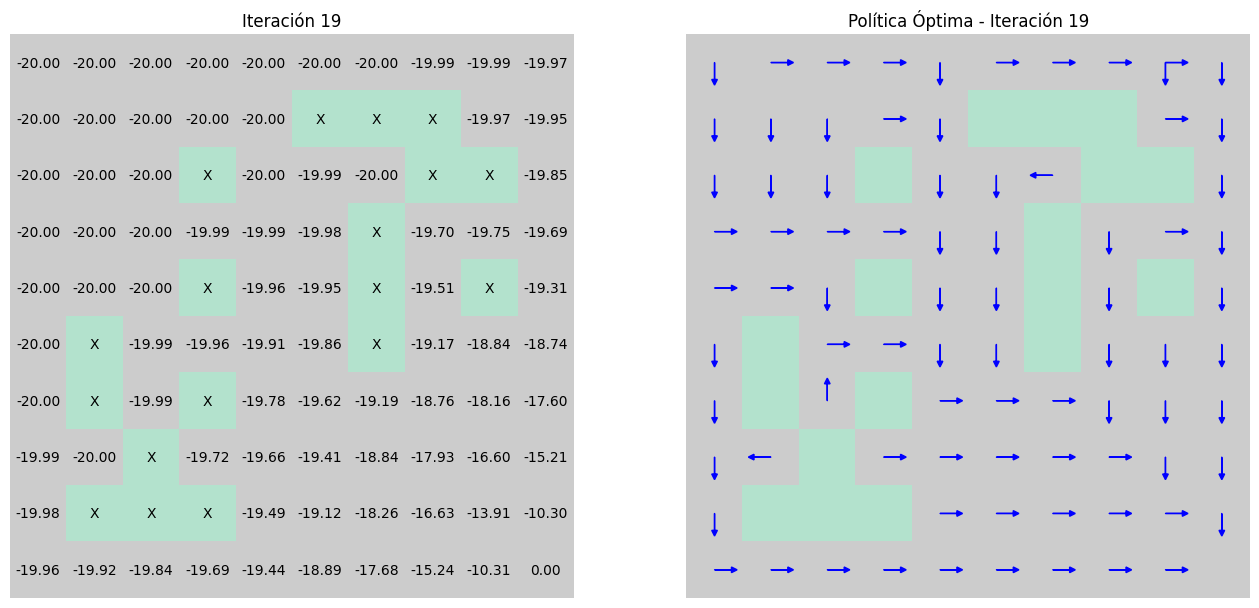

In [8]:
# @title Ejecución del experimento
# Ejecutamos el proceso iterativo, mostrando la evolución en cada iteración.

sync = True  # Si se quiere síncrono o no
maze = Maze(n, m, p_obstacle=p_obstacle, seed=42) # Instanciamos un laberinto
visualizer = Visualizer(maze)                     # Instanciamos el visualizado
policy = UniformPolicy(maze)                      # Instanciamos una política
policy_visualizer = PolicyVisualizer(maze, gamma=gamma, reward_step=-1)
value_iteration = ValueIteration(maze, policy, gamma=gamma, reward_step=-1)  # Instanciamos la evaluación de la función valor

# Ejecutamos las iteraciones y mostramos los resultados.
value_iteration.iterate(max_iter=max_iter, tol=tol, delay=delay, is_sync=sync, visualizer=visualizer, policy_visualizer=policy_visualizer)

---

La imagen obtenida representa dos visualizaciones clave en la solución de un problema de decisión de Markov (MDP) aplicado a un laberinto con obstáculos:

1. **Izquierda: Evaluación de la Función Valor \(V(s)\)**
2. **Derecha: Política Óptima $\pi^*(s)$**

Cada una de estas visualizaciones nos proporciona información sobre la dinámica del agente en el entorno y su comportamiento óptimo basado en la ecuación de Bellman.

---

# Conclusiones del Resultado Obtenido


## Análisis de la Función Valor $V(s)$ (Gráfica Izquierda)

- Al tener un costo de -1 en cada paso, los valores de estado deben tender el **número de pasos esperados** para llegar al estado terminal/objetivo.

- Se observa que la celda final (abajo a la derecha) tiene un valor de **0**, lo que es consistente con la definición del problema (costo acumulativo mínimo).
- A medida que nos alejamos de la meta, los valores de estado disminuyen progresivamente en una distribución casi uniforme.
  - Por ejemplo. Los dos más próximos al objetivo tienen el mismo coste de 10.3. Los siguientes más próximo tienen costo 15.2 y 13.9. Si se continua ese recorrido, se observa una simetría respecto de la digonal que va del estado inicial al estado final y con valos muy parecidos.

- Los valores más altos (menos negativos) están cerca de la meta, lo que significa que el agente tiene una ruta más corta a la recompensa.
- Los valores más bajos (más negativos) se encuentran en las celdas más alejadas, lo que indica que, al iniciar desde esas posiciones, el agente tardará más en llegar a la meta y, por lo tanto, acumulará un mayor costo negativo.

- Se observa que los valores de estado alrededor de los obstáculos son más bajos debido a la necesidad de rodear estos elementos para llegar a la meta.
Esto sugiere que los estados cercanos a grandes bloqueos tienen un impacto directo en la trayectoria óptima, forzando caminos alternativos con costos más elevados.

- En un entorno sin obstáculos, se esperaría una distribución simétrica de los valores de estado. La presencia de obstáculos altera esta simetría y genera "zonas de congestión" donde las rutas óptimas se ven desviadas.

---

## Análisis de la Política Óptima $\pi^*(s)$ (Gráfica Derecha)

- Las flechas indican la acción óptima en cada estado transitable.

- Se observa un **patrón general** descendente y hacia la derecha en la política, lo que significa que la mejor estrategia es moverse hacia abajo y hacia la derecha en la mayoría de los casos.

- La combinación de flechas hacia abajo y hacia la derecha es **una estrategia** esperada en este problema de búsqueda de camino óptimo en un entorno de recompensa negativa**.

- En algunas regiones, las flechas apuntan hacia la izquierda o hacia arriba, que se corresponda con la imposibilidad de realizar la política abajo-derecha por la aparición de obstáculos.
  - Se observa que cerca de los obstáculos las flechas muestran un comportamiento de **rodeo**, lo que significa que el agente está encontrando el mejor camino alternativo para evitar esas celdas bloqueadas.

- No cabe esperar que en iteraciones sucesivas la política cambie demasiado. Si acaso, algún estado con flecha a la derecha termine con una flecha hacia la derecha y hacia abajo (pero es altamente improbable porque es dificil que dos número reales lleguen a ser iguales).

- La imagen sugiere que la política ha alcanzado la convergencia, ya que la estructura de las flechas sigue un patrón ordenado que permite llegar al estado terminal sin rodeos.
  - Y eso a pesar de que la función de valor (imagen izquierda) **aun tiene muchos estados con el mismo valor** - valores que necesariemente tendrán que cambiar.



## **Conclusiones Finales**

1. Experimentalmente hemos comprobado que **el proceso del cálculo iterativo de la función valor tiende a la solución de las ecuaciones de Bellman**.
  - TODO: Realmente habría que calcular las soluciones de las ecuaciones de Bellman (mediante cálculo de matrices inversas) y compararlas con la solución obtenida en la figura de la izquierda. Se deja como ejercicio

1. **El modelo ha convergido a una política óptima estable**, lo que significa que el algoritmo de iteración de valor ha funcionado correctamente.

1. **La función valor muestra una transición suave** desde estados alejados hasta la meta, con valores decrecientes progresivamente.

1. **Los obstáculos tienen un impacto visible en la función valor y en la política**, desviando la trayectoria óptima y generando caminos alternativos.

1. **El comportamiento del agente es consistente con la formulación de un MDP**, moviéndose en la dirección que minimiza el costo total.



---

